# Overview ##

This notebook creates a basic logistic regression model based on the seed differences and season average metric differences (e.g., FG%, PPG, Opp. PPG) between teams. 

Note that the model is trained entirely on data from 2003-2017 and their known outcomes. The resulting classifier is then used on 2018 data to generate predictions for this year's tournament on March 11.

In [288]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV


## Load the training data ##
We're keeping it relatively simple & using only a handful files for this model: the tourney seeds, tourney results, and a detailed results dataset to calculate our other features.

In [289]:
data_dir = '../input/'
df_seeds = pd.read_csv(data_dir + 'DataFiles' + '/' + 'NCAATourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'DataFiles' + '/' + 'NCAATourneyCompactResults.csv')

# We load detailed season data to calculate season average statistics for each team
df_reg_season_detailed = pd.read_csv(data_dir + 'PrelimData2018' + '/' + 'RegularSeasonDetailedResults_Prelim2018.csv')
df_reg_season_detailed.drop(labels=['WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WDR', 'WAst', 'WStl', 'WBlk', 'WPF',
                                   'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LDR', 'LAst', 'LStl', 'LBlk', 'LPF'], inplace=True, axis=1)
df_reg_season_detailed.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WOR,WTO,LFGM,LFGA,LOR,LTO
0,2003,10,1104,68,1328,62,N,0,27,58,14,23,22,53,10,18
1,2003,10,1272,70,1393,63,N,0,26,62,15,13,24,67,20,12
2,2003,11,1266,73,1437,61,N,0,24,58,17,10,22,73,31,12
3,2003,11,1296,56,1457,50,N,0,18,38,6,12,18,49,17,19
4,2003,11,1400,77,1208,71,N,0,30,61,17,14,24,62,21,10


## Create a new data frame with season average metrics ##
We are creating a new data frame with season average statistics for each team for use as features in our machine learning algorithm.

In [290]:
# TODO: Other statistics I should investigate:
#   -wins! (seems like an obvious one)
#   -offensive rebounds
#   -get to the foul line frequently

#   -Also look into player/team efficiency
#   -Avg win shares/min per team
#   -Should use MasseyOrdinals dataset (rating and ranking system data)
# Strength of Schedule!

# TODO: Neaten up code and break into other functions
# TODO: Investigate performance -- e.g., should avoid creating new data frames

yearList = range(2003,2004) #2003 is the first year we have detailed data for..
teams_pd = pd.read_csv(data_dir + 'DataFiles' + '/' + 'Teams.csv')
teamIDs = teams_pd['TeamID'].tolist()

rows = list()

for year in yearList:
    for team in teamIDs:
        df_curr_season = df_reg_season_detailed[df_reg_season_detailed.Season == year]       

        df_curr_team_wins = df_curr_season[df_curr_season.WTeamID == team]
        df_curr_team_losses = df_curr_season[df_curr_season.LTeamID == team]
        
        # no games played by them this year.. skip (current team didn't win or lose any games)
        if df_curr_team_wins.shape[0] == 0 and df_curr_team_losses.shape[0] == 0:
            continue;
        
        df_winteam = df_curr_team_wins.rename(columns={'WTeamID':'TeamID', 'WFGM':'FGM', 'WFGA':'FGA', 'WTO':'TO', 
                                                       'WScore':'Score', 'LScore':'OppScore'})
        df_winteam = df_winteam[['TeamID', 'FGM', 'FGA', 'TO', 
                                 'Score', 'OppScore']] # drop all columns except the ones we are using

        df_loseteam = df_curr_team_losses.rename(columns={'LTeamID':'TeamID', 'LFGM':'FGM', 'LFGA':'FGA', 'LTO':'TO', 
                                                          'LScore':'Score', 'WScore':'OppScore'})
        df_loseteam = df_loseteam[['TeamID', 'FGM', 'FGA', 'TO', 
                                   'Score', 'OppScore']] # drop all columns except the ones we are using

        df_curr_team = pd.concat((df_winteam, df_loseteam)) # dataframe w/ all relevant stats from current year for current team

        FGPercent = df_curr_team['FGM'].sum() / df_curr_team['FGA'].sum()
        TurnoverAvg = df_curr_team['TO'].sum() / len(df_curr_team['TO'].values)
        PPG = df_curr_team['Score'].sum() / len(df_curr_team['Score'].values)
        OppPPG = df_curr_team['OppScore'].sum() / len(df_curr_team['OppScore'].values)

        # collect all data in rows list first for effeciency
        rows.append([year, team, FGPercent, TurnoverAvg, PPG, OppPPG])

df_training_data = pd.DataFrame(rows, columns=['Season', 'TeamID', 'FGPercent', 'TOAvg', 'PPG', 'OppPPG'])
df_training_data.head()

,Season,TeamID,FGPercent,TOAvg,PPG,OppPPG
0,2003,1102,0.481149,11.428571,57.250000,57.000000
1,2003,1103,0.486074,12.629630,78.777778,78.148148
2,2003,1104,0.420362,13.285714,69.285714,65.000000
3,2003,1105,0.395755,18.653846,71.769231,76.653846
4,2003,1106,0.423773,17.035714,63.607143,63.750000


Here we show the contents of our (currently) simple model. We will (for now) only predict using the data frames constructed by team seedings and tournament results.

In [291]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [292]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


First, we'll simplify the datasets to remove the columns we won't be using and convert the seedings to the needed format (stripping the regional abbreviation in front of the seed).

In [293]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label
df_seeds.head()

,Season,TeamID,seed_int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [294]:
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


## Merge seed for each team ##
Merge the Seeds with their corresponding TeamIDs in the compact results dataframe.

In [295]:
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


Now we'll combine our advanced season statistics and merge them into the df_concat data frame.

In [296]:
df_winstats = df_training_data.rename(columns={'TeamID':'WTeamID', 'FGPercent':'WFGPercent', 'TOAvg':'WTOAvg', 
                                               'PPG':'WPPG', 'OppPPG':'WOppPPG'})
df_lossstats = df_training_data.rename(columns={'TeamID':'LTeamID', 'FGPercent':'LFGPercent', 'TOAvg':'LTOAvg', 
                                                'PPG':'LPPG', 'OppPPG':'LOppPPG'})
df_dummy = pd.merge(left=df_concat, right=df_winstats, on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossstats, on=['Season', 'LTeamID'])
df_concat['FGPercentDiff'] = df_concat.WFGPercent - df_concat.LFGPercent
df_concat['TOAvgDiff'] = df_concat.WTOAvg - df_concat.LTOAvg
df_concat['PPGDiff'] = df_concat.WPPG - df_concat.LPPG
df_concat['OppPPGDiff'] = df_concat.WOppPPG - df_concat.LOppPPG
df_concat['WWinMargin'] = df_concat.WPPG - df_concat.WOppPPG
df_concat['LWinMargin'] = df_concat.LPPG - df_concat.LOppPPG
df_concat['WinMarginDiff'] = df_concat.WWinMargin - df_concat.LWinMargin
df_concat = df_concat[['Season', 'WTeamID', 'LTeamID', 'SeedDiff', 'FGPercentDiff', 'TOAvgDiff', 
                       'PPGDiff', 'OppPPGDiff', 'WinMarginDiff']] # drop all columns except the ones we are using


df_concat.head() #keep in mind we can have SeedDiff == 0 due to the First Four (68 teams)! Also Final Four onwards!

# Keep in mind that these merges tossed out data from before 2003

,Season,WTeamID,LTeamID,SeedDiff,FGPercentDiff,TOAvgDiff,PPGDiff,OppPPGDiff,WinMarginDiff
0,2003,1421,1411,0,-0.018262,0.973563,-1.593103,7.614943,-9.208046
1,2003,1112,1436,-15,0.016969,0.716749,17.421182,7.112069,10.309113
2,2003,1112,1211,-8,-0.008628,0.237327,8.149770,2.056452,6.093318
3,2003,1112,1323,-4,0.012716,2.011521,5.117512,-0.943548,6.061060
4,2003,1113,1272,3,0.040251,0.206897,1.448276,3.344828,-1.896552


Now we'll create a dataframe that summarizes wins & losses along with their corresponding seed differences, FG% differences, and turnover differences. This is the meat of what we'll be creating our model on.

In [297]:
# We create positive and negative versions of the data so the 
# supervised learning algorithm has sample data of each class to classify

df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['FGPercentDiff'] = df_concat['FGPercentDiff']
df_wins['TOAvgDiff'] = df_concat['TOAvgDiff']
df_wins['PPGDiff'] = df_concat['PPGDiff']
df_wins['OppPPGDiff'] = df_concat['OppPPGDiff']
df_wins['WinMarginDiff'] = df_concat['WinMarginDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['FGPercentDiff'] = -df_concat['FGPercentDiff']
df_losses['TOAvgDiff'] = -df_concat['TOAvgDiff']
df_losses['PPGDiff'] = -df_concat['PPGDiff']
df_losses['OppPPGDiff'] = -df_concat['OppPPGDiff']
df_losses['WinMarginDiff'] = -df_concat['WinMarginDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,FGPercentDiff,TOAvgDiff,PPGDiff,OppPPGDiff,WinMarginDiff,Result
0,0,-0.018262,0.973563,-1.593103,7.614943,-9.208046,1
1,-15,0.016969,0.716749,17.421182,7.112069,10.309113,1
2,-8,-0.008628,0.237327,8.149770,2.056452,6.093318,1
3,-4,0.012716,2.011521,5.117512,-0.943548,6.061060,1
4,3,0.040251,0.206897,1.448276,3.344828,-1.896552,1


In [298]:
X_train = [list(a) for a in zip(df_predictions.SeedDiff.values, df_predictions.FGPercentDiff.values, 
                                df_predictions.TOAvgDiff.values, df_predictions.PPGDiff.values,
                                df_predictions.OppPPGDiff.values, df_predictions.WinMarginDiff.values)]
X_train = np.array(X_train)
y_train = df_predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)

## Train the model ##
Use a basic logistic regression to train the model. You can set different C values to see how performance changes.

In [299]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=11)} # {C: array[1^-5 , 1^-4, ... 1^5] }
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True) #sklearn model selection
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

# Just based on seeds - Logistic Regression
# Best log_loss: -0.5531, with best C: 0.01
# Best log_loss: -0.5529, with best C: 0.1

# TODO: results with our 6 features
# Seeds, average FG%, and average turnovers - Logistic Regression
# Best log_loss: -0.5187, with best C: 1000.0

Best log_loss: -0.5017, with best C: 10000.0


Text(0,0.5,'P(Team1 will win)')

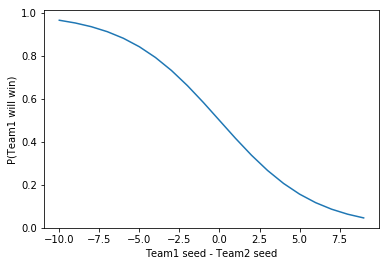

In [300]:
X1 = np.arange(-10, 10)
X2 = np.zeros(20, dtype=np.int)
X = [list(a) for a in zip(X1, X2, X2, X2, X2, X2)]
X = np.array(X)

preds = clf.predict_proba(X)[:,1]

plt.plot(X1, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

Plotting validates our intuition, that the probability a team will win decreases as the seed differential to its opponent decreases.

In [306]:
df_sample_sub = pd.read_csv(data_dir + 'SampleSubmissionStage2.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

In [307]:
X_test = np.zeros(shape=(n_test_games, 6))

#TODO: Fill in X_test with proper data from the 2018 season!

# for ii, row in df_sample_sub.iterrows():
#     year, t1, t2 = get_year_t1_t2(row.ID)
#     t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
#     t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
#     diff_seed = t1_seed - t2_seed
#     X_test[ii, 0] = diff_seed
    
#     print(df_training_data[(df_training_data.TeamID == t1) & (df_training_data.Season == year)].FGPercent.values[0])
#     break; #hmm missing some data...?
    
#     t1_FGPercent = df_training_data[(df_training_data.TeamID == t1) & (df_training_data.Season == year)].FGPercent.values[0]
#     t2_FGPercent = df_training_data[(df_training_data.TeamID == t2) & (df_training_data.Season == year)].FGPercent.values[0]
#     diff_FGPercent = t1_FGPercent - t2_FGPercent
#     X_test[ii, 1] = diff_FGPercent
print(X_test)

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


## Make Predictions ##
Create predictions using the logistic regression model we trained.

In [308]:
preds = clf.predict_proba(X_test)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

,ID,Pred
0,2018_1104_1112,0.5
1,2018_1104_1113,0.5
2,2018_1104_1116,0.5
3,2018_1104_1120,0.5
4,2018_1104_1137,0.5


Lastly, create your submission file!

In [309]:
df_sample_sub.to_csv('predictions.csv', index=False)